In [3]:
import sys
sys.path.append("../")
import numpy as np
from sanchez_ansatz import SanchezAnsatz
from experiments.create_state import get_state
import matplotlib.pyplot as plt

%matplotlib inline

### Normal distribution

### Black-Scholes

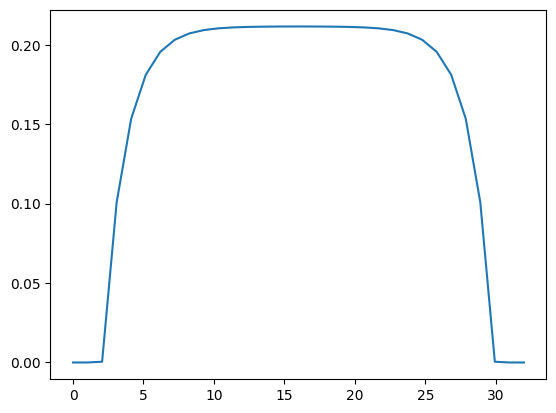

In [28]:
interval = (-10, 10)

state_params = {"x_points": interval, "K": 45, "c": 3}

num_qubits = 5
x_points = np.linspace(0, 2**num_qubits, 2**num_qubits)
black_scholes_state = get_state(num_qubits, "black-scholes", state_params)

plt.plot(x_points, black_scholes_state)
plt.show()
